In [25]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.signal import detrend
from scipy.ndimage import uniform_filter1d
from io import StringIO 

Text(0.5, 1.0, 'Single Galactic Observation at Longitude 165°')

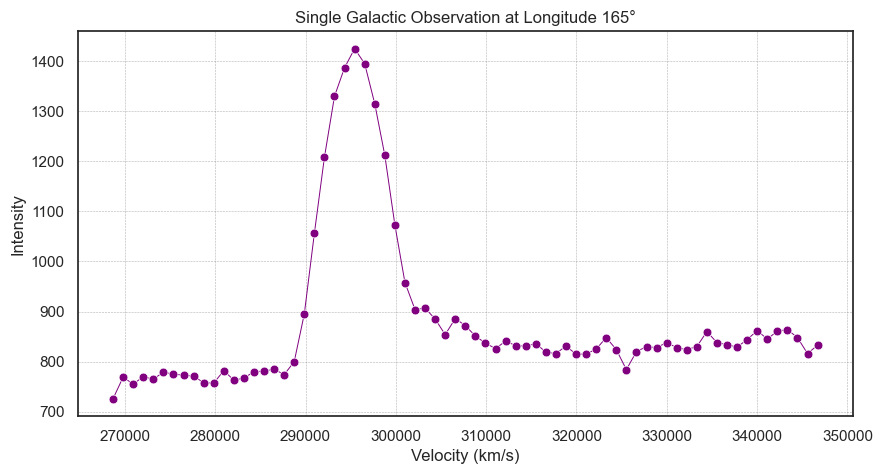

In [41]:
# Define constants
SPEED_OF_LIGHT_KMS = 3e5         
HI_REST_FREQ_MHZ = 1420.4      

# Load observation data 
csv_file = r"C:\Users\Hareethha\Downloads\milkyway\Group 4\054_165.csv"

# Parse and label data 
columns = ["Channel", "Frequency", "Timestamp", "Intensity"]
data = pd.read_csv(csv_file, skiprows=1, names=columns)

# Convert numerical fields and clean 
data["Frequency"] = pd.to_numeric(data["Frequency"], errors="coerce")
data["Intensity"] = pd.to_numeric(data["Intensity"], errors="coerce")
data.dropna(inplace=True)

# Compute radial velocity via Doppler shift 
def frequency_to_velocity(freq_mhz):
    return SPEED_OF_LIGHT_KMS * (HI_REST_FREQ_MHZ - freq_mhz) / HI_REST_FREQ_MHZ

data["Velocity"] = data["Frequency"].apply(frequency_to_velocity)
data.sort_values("Velocity", inplace=True)

# Seaborn Theme and Plot
sns.set_theme(style="white", palette="deep")  
plt.figure(figsize=(10, 5))
sns.lineplot(
    x="Velocity",
    y="Intensity",
    data=data,
    linestyle="-",
    color="purple",
    linewidth=0.7,
    marker=None
)
sns.scatterplot(
    x="Velocity",
    y="Intensity",
    data=data,
    color="purple",      
    s=40,                
    marker="o",
    zorder=10            
)

# Customize Grid and Axis 
plt.grid(
    visible=True,
    which='both',
    linestyle='--',
    linewidth=0.4,
    alpha=0.6,
    color='gray')
plt.xlabel("Velocity (km/s)", fontsize=12)
plt.ylabel("Intensity", fontsize=12)
plt.title("Single Galactic Observation at Longitude 165°")

C:\Users\Hareethha\AppData\Local\Temp\ipykernel_12908\816375661.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("inferno")


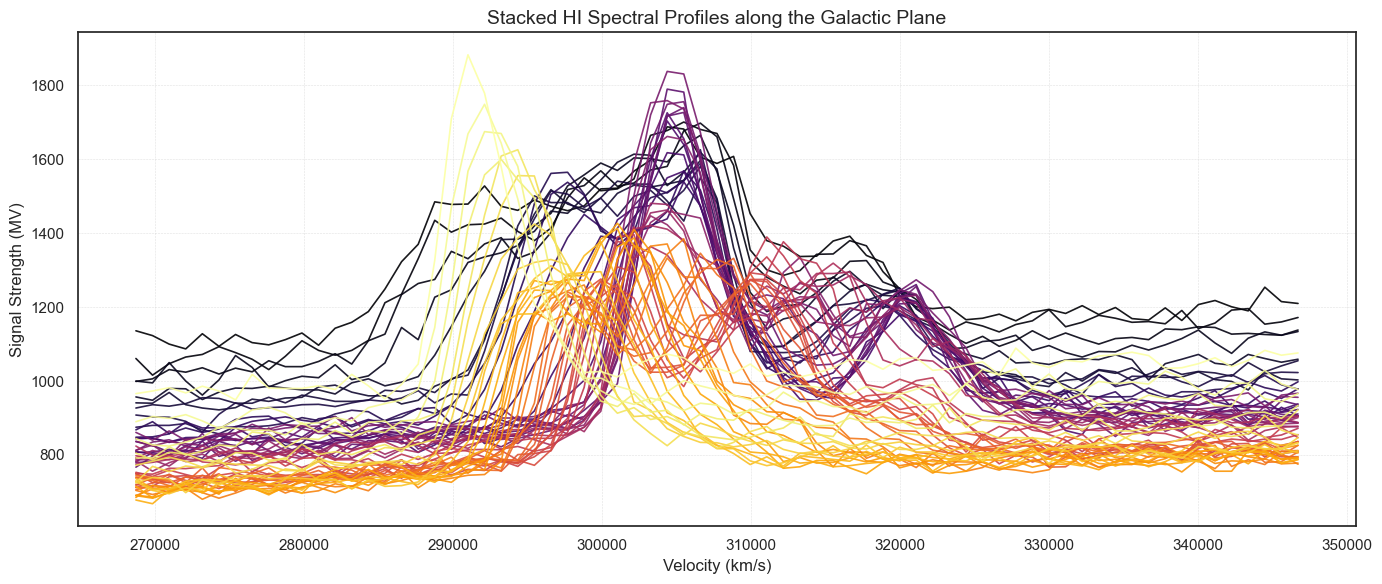

In [39]:
# Global Constants 
C = 3e5             
F_REST = 1420.4     

DATA_DIR = Path(r"C:\Users\Hareethha\Downloads\milkyway\Group 4")  

# Function: Extract Galactic Longitude
def extract_longitude(filename):
    try:
        return float(filename.stem.split("_")[1])
    except:
        return None


# Function: Process a Single File 
def process_file(file_path):
    try:
        df = pd.read_csv(file_path, skiprows=1, names=["Channel", "Frequency", "Timestamp", "Intensity"])
        df["Frequency"] = pd.to_numeric(df["Frequency"], errors="coerce")
        df["Intensity"] = pd.to_numeric(df["Intensity"], errors="coerce")
        df.dropna(inplace=True)

        # Calculate radial velocity
        df["Velocity"] = C * (F_REST - df["Frequency"]) / F_REST
        df.sort_values("Velocity", inplace=True)

        # Return average spectrum
        return df.groupby("Velocity")["Intensity"].mean()

    except Exception as e:
        print(f"Failed to process {file_path.name}: {e}")
        return None


# Function: Load All Spectra 
def load_spectra(data_dir):
    spectra = {}
    for file in sorted(data_dir.glob("*.csv")):
        gal_lon = extract_longitude(file)
        if gal_lon is not None:
            spectrum = process_file(file)
            if spectrum is not None:
                spectra[gal_lon] = spectrum
    return spectra


# Function: Plot Spectra 
def plot_spectra(spectra, show_legend=False):
    import matplotlib.cm as cm

    plt.figure(figsize=(14, 6))
    gal_lons = sorted(spectra.keys())
    norm = plt.Normalize(min(gal_lons), max(gal_lons))
    cmap = cm.get_cmap("inferno")  

    for gal_lon in gal_lons:
        spectrum = spectra[gal_lon]
        plt.plot(
            spectrum.index,
            spectrum.values,
            color=cmap(norm(gal_lon)),
            alpha=0.9,
            linewidth=1.2,
            label=f"{gal_lon:.1f}°"
        )

    plt.xlabel("Velocity (km/s)", fontsize=12)
    plt.ylabel("Signal Strength (MV)", fontsize=12)
    plt.title("Composite HI Spectra Across Galactic Plane", fontsize=14)
    plt.grid(True, linestyle="--", linewidth=0.4, alpha=0.6)

    if show_legend:
        plt.legend(title="Longitude", bbox_to_anchor=(1.02, 1), loc="upper left", fontsize="x-small")

    plt.tight_layout()
    plt.show()

#  Main Routine 
if __name__ == "__main__":
    all_spectra = load_spectra(DATA_DIR)
    plot_spectra(all_spectra, show_legend=False) 


 Could not extract longitude from 001_30 - Copy.csv: could not convert string to float: '30 - Copy'


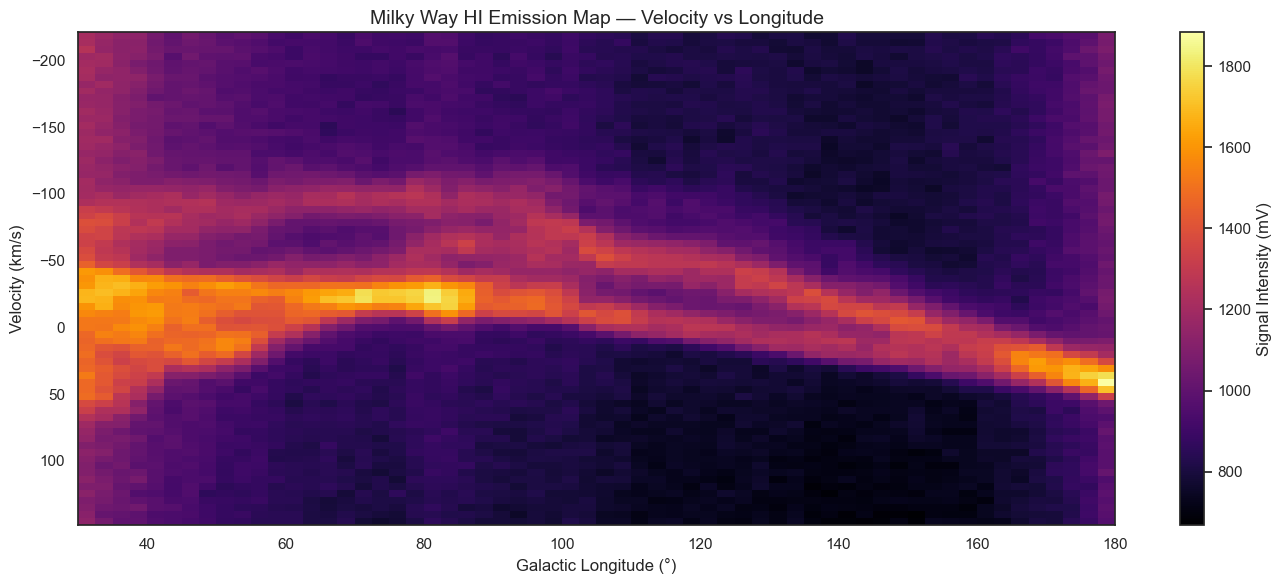

In [37]:

DATA_DIR = Path(r"C:\Users\Hareethha\Downloads\milkyway\Group 4")  

# Function: Extract Galactic Longitude 
def extract_longitude(filename):
    try:
        return float(filename.stem.split("_")[1])
    except Exception as e:
        print(f" Could not extract longitude from {filename.name}: {e}")
        return None


# Function: Load and Process a Single File 
def process_spectrum(file_path):
    try:
        df = pd.read_csv(file_path, skiprows=1, names=["Channel", "Velocity_kms", "Time", "Millivolts"])
        df["Velocity_kms"] = pd.to_numeric(df["Velocity_kms"], errors="coerce")
        df["Millivolts"] = pd.to_numeric(df["Millivolts"], errors="coerce")
        df.dropna(inplace=True)

        return df.groupby("Velocity_kms")["Millivolts"].mean()
    
    except Exception as e:
        print(f" Skipping {file_path.name}: {e}")
        return None


# Function: Load All Spectra 
def load_all_spectra(data_dir):
    spectra = {}
    for file in sorted(data_dir.glob("*.csv")):
        gal_lon = extract_longitude(file)
        if gal_lon is not None:
            spectrum = process_spectrum(file)
            if spectrum is not None:
                spectra[gal_lon] = spectrum
    return spectra


# Function: Format Combined DataFrame 
def prepare_dataframe(spectra_dict):
    df = pd.DataFrame(spectra_dict)
    df.columns = pd.to_numeric(df.columns, errors="coerce")
    df.index = pd.to_numeric(df.index, errors="coerce")
    df.dropna(axis=0, how="all", inplace=True)
    df.dropna(axis=1, how="all", inplace=True)
    df.fillna(0, inplace=True)
    return df.sort_index(axis=1)  

# Function: Plot Heatmap
def plot_velocity_longitude_heatmap(data, cmap="viridis"):
    plt.figure(figsize=(14, 6))
    plt.imshow(
        data,
        aspect='auto',
        cmap=cmap,
        extent=[
            data.columns.min(), data.columns.max(),
            data.index.max(), data.index.min()]
    )

    plt.colorbar(label="Signal Intensity (mV)")
    plt.xlabel("Galactic Longitude (°)", fontsize=12)
    plt.ylabel("Velocity (km/s)", fontsize=12)
    plt.title("Milky Way HI Emission Map — Velocity vs Longitude", fontsize=14)
    plt.grid(False)
    plt.tight_layout()
    plt.show()


# Main Routine 
if __name__ == "__main__":
    spectra_dict = load_all_spectra(DATA_DIR)
    combined_df = prepare_dataframe(spectra_dict)
    plot_velocity_longitude_heatmap(combined_df, cmap="inferno")  


📡 Source: CasA
Fringe Amplitude: 61.59 mV  |  0.0616 V
Estimated Flux:   1836.16 Jy (using calibration 29810.57 Jy/V)


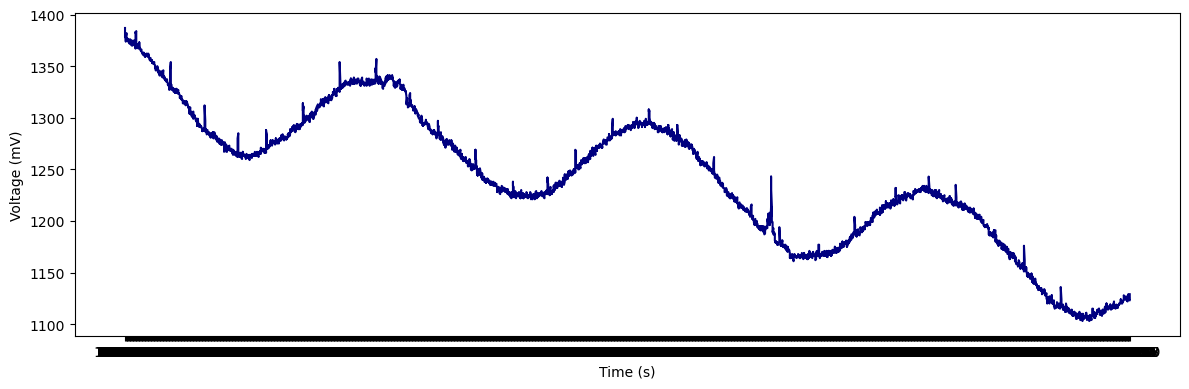

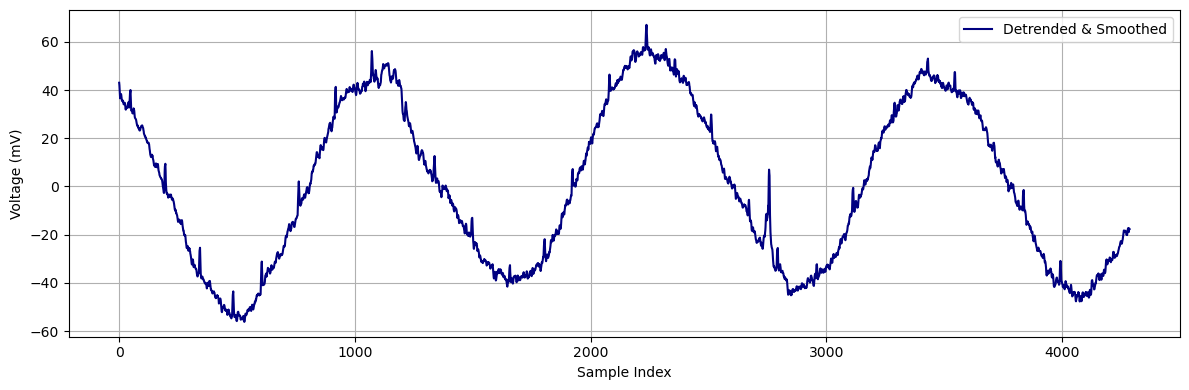

In [118]:
# PARAMETERS
FILE_PATH = r"C:\Users\Hareethha\Downloads\Cas_A_002.csv"
SOURCE_NAME = "CasA"
JY_PER_VOLT = 29810.57  

# LOAD & CLEAN DATA
def load_interferometer_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    data_str = "".join(lines[1:])  # Skip timestamp line
    df = pd.read_csv(StringIO(data_str), names=["Time", "Millivolts"]) 
    df["Millivolts"] = pd.to_numeric(df["Millivolts"], errors="coerce")
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df["Sample"] = df.index
    return df

# PROCESS SIGNAL 
def process_signal(df):
    raw = df["Millivolts"].values
    detrended = detrend(raw)
    smoothed = uniform_filter1d(detrended, size=5)
    return smoothed


# ESTIMATE AMPLITUDE 
def estimate_amplitude(signal):
    amp_mV = (np.max(signal) - np.min(signal)) / 2
    amp_V = amp_mV * 1e-3
    return amp_mV, amp_V

# CALCULATE FLUX 
def convert_to_flux(amp_V, jy_per_volt):
    return amp_V * jy_per_volt

# PLOTTING FUNCTIONS 
def plot_raw(df, source):
    plt.figure(figsize=(12, 4), facecolor='white')  # Set background
    plt.plot(df["Time"], df["Millivolts"], color="navy")
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (mV)")
    plt.tight_layout()
    plt.savefig("CasA-pic1.jpg", dpi=300)

def plot_processed(df, smoothed, source):
    plt.figure(figsize=(12, 4), facecolor='white')  # Set background
    plt.plot(df["Sample"], smoothed, label="Detrended & Smoothed",color="navy")
    plt.xlabel("Sample Index")
    plt.ylabel("Voltage (mV)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("CasA-pic2.jpg", dpi=300)

# MAIN EXECUTION ---
df = load_interferometer_data(FILE_PATH)
smoothed_signal = process_signal(df)
amp_mV, amp_V = estimate_amplitude(smoothed_signal)
flux_jy = convert_to_flux(amp_V, JY_PER_VOLT)

# --- OUTPUT ---
print(f"📡 Source: {SOURCE_NAME}")
print(f"Fringe Amplitude: {amp_mV:.2f} mV  |  {amp_V:.4f} V")
print(f"Estimated Flux:   {flux_jy:.2f} Jy (using calibration {JY_PER_VOLT} Jy/V)")

# --- PLOTS ---
plot_raw(df, SOURCE_NAME)
plot_processed(df, smoothed_signal, SOURCE_NAME)


📡 Estimated Fringe Amplitude for Cygnus A: 53.00 mV
🔌 Converted to Volts: 0.0530 V


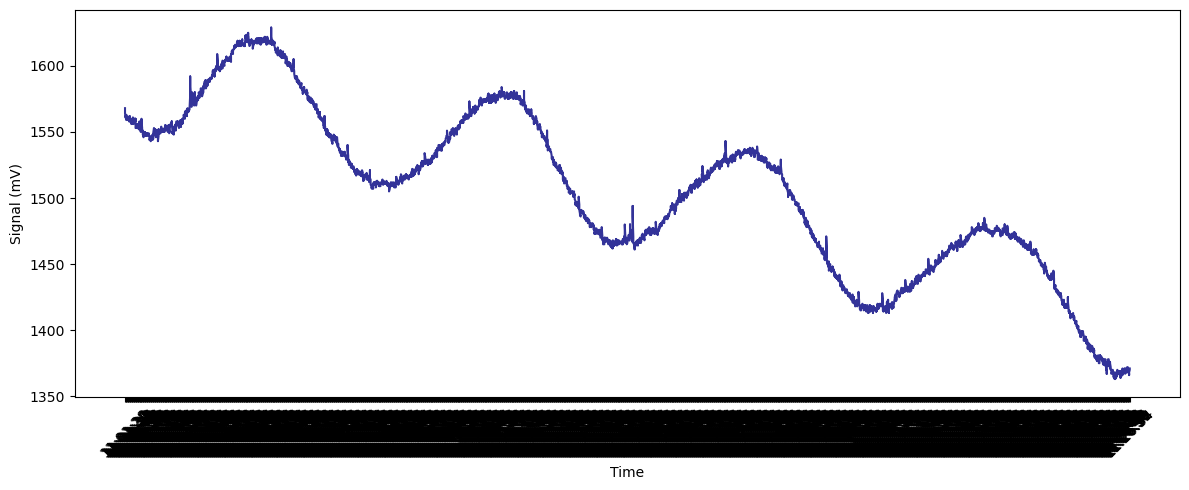

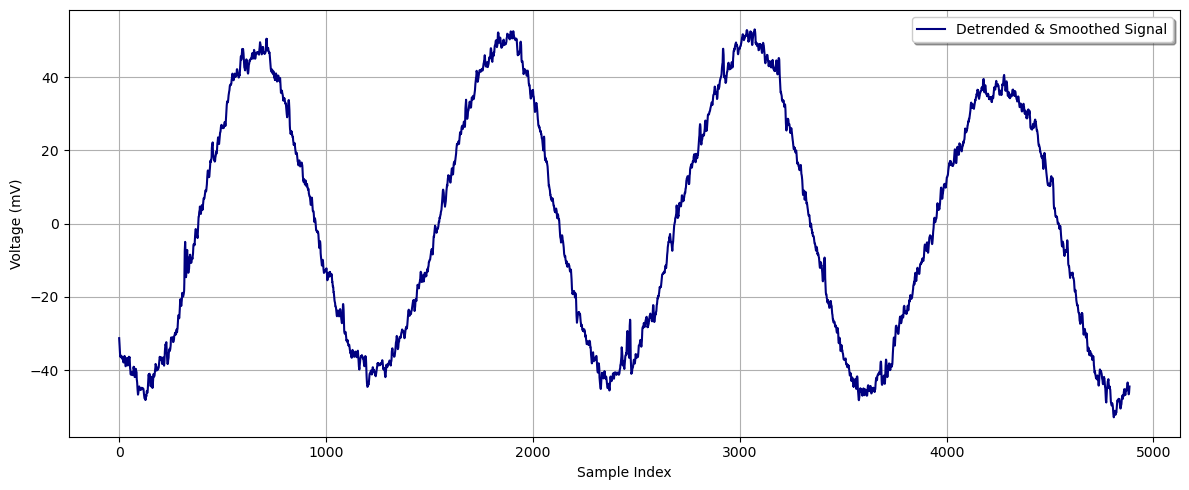

In [120]:

# PARAMETERS 
FILE_PATH = r"C:\Users\Hareethha\Downloads\cygnus_001.csv"
SOURCE_NAME = "Cygnus A"

# Load and clean the CSV data 
def load_data_skip_header(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    data_str = "".join(lines[1:])  # Skip first timestamp row
    df = pd.read_csv(StringIO(data_str), names=["Time", "Millivolts"])
    df["Millivolts"] = pd.to_numeric(df["Millivolts"], errors="coerce")
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df["Sample"] = df.index
    return df

# Detrend and smooth the signal 
def process_signal(voltage_series, smooth_window=5):
    detrended = detrend(voltage_series)
    smoothed = uniform_filter1d(detrended, size=smooth_window)
    return smoothed

# Estimate fringe amplitude 
def estimate_amplitude(signal):
    peak_to_peak = np.max(signal) - np.min(signal)
    amp_mV = peak_to_peak / 2
    amp_V = amp_mV * 1e-3
    return amp_mV, amp_V

# Plotting functions 
def plot_raw(df, source):
    plt.figure(figsize=(12, 5))
    plt.plot(df["Time"], df["Millivolts"], linestyle='-', alpha=0.8, color='navy')
    plt.xticks(rotation=45)
    plt.xlabel("Time")
    plt.ylabel("Signal (mV)")
    plt.tight_layout()
    plt.savefig("Cygnus-plot1.jpg", dpi =300)

def plot_processed(df, smoothed, source):
    plt.figure(figsize=(12, 5))
    plt.plot(df["Sample"], smoothed, label="Detrended & Smoothed Signal", color="navy")
    plt.xlabel("Sample Index")
    plt.ylabel("Voltage (mV)")
    plt.grid(True)
    plt.legend(shadow=True)
    plt.tight_layout()
    plt.savefig("Cygnus-plot2.jpg", dpi =300)

# --- MAIN EXECUTION ---
df = load_data_skip_header(FILE_PATH)
plot_raw(df, SOURCE_NAME)

smoothed = process_signal(df["Millivolts"])
amp_mV, amp_V = estimate_amplitude(smoothed)

# --- RESULTS ---
print(f"📡 Estimated Fringe Amplitude for {SOURCE_NAME}: {amp_mV:.2f} mV")
print(f"🔌 Converted to Volts: {amp_V:.4f} V")

plot_processed(df, smoothed, SOURCE_NAME)
